# Tweet Anomaly Detection
In this project we will be using a dataset that contains the daily volume of tweets about Apple and using this to detect anomalies. This data set can be downloaded from here: https://www.kaggle.com/boltzmannbrain/nab We will be looking at anomalies in volume of tweets in intraday time periods and also in daily time periods. We will be using a couple different methods of classifing anomalies. Then we will evaluate which method is better for detecting anomalies on our dataset.

lets start by importing necessary libraries

In [1]:
import pandas as pd 
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance
import matplotlib.pyplot as plt
%matplotlib inline

In C:\Users\brand\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\brand\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\brand\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\brand\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\brand\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

lets read in our dataset

In [2]:
df = pd.read_csv("Twitter_volume_AAPL.csv")

lets check out our data

In [3]:
df["value"].describe()

count    15902.000000
mean        85.552320
std        321.050721
min          0.000000
25%         29.000000
50%         47.000000
75%         76.000000
max      13479.000000
Name: value, dtype: float64

Here we can see that the average volume of tweets per time period is about 86. Right off the bat we can see the max is way higher than the average so we know there are anomalies in this dataset.

In [4]:
df.isnull().sum()

timestamp    0
value        0
dtype: int64

There are no empty values

Next we will find anomalies with Interquartile ranges. We will return True if the value is not in the range (Q1 - 1.5 * IQR))(Q3 + 1.5 * IQR)

In [5]:
def getIQROutlier(series, data, name = "IQR Outlier"):
    Q1 = data[series].quantile(0.25)
    Q3 = data[series].quantile(0.75)
    IQR = Q3 - Q1
    data[name] = (data[series] < (Q1 - 1.5 * IQR)) |(data[series] > (Q3 + 1.5 * IQR))
    normalValues = "number of Normal Values: " + str(data[name].value_counts()[0])
    abnormalValues = "number of Outlier Values: " + str(data[name].value_counts()[1])
    percent = str(data[name].value_counts()[1]/data[name].value_counts()[0]) + "% of the data are outliers"
    print(normalValues)
    print(abnormalValues)
    print(percent)
    data.boxplot(column=series, by=name)

number of Normal Values: 14652
number of Outlier Values: 1250
0.08531258531258532% of the data are outliers


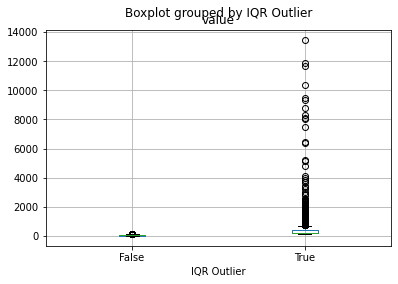

In [6]:
getIQROutlier("value",df)

Our current anomaly detection method has around 8% of the data classified as an anomaly. Lets keep a count of daily tweets and see if we can find more outliers. We start by splitting the date up by year, month, and day and them group them together.

In [7]:
df["date"]=[d.date() for d in df['timestamp'].astype('datetime64[ns]')]
df[["year", "mm", "day"]] = df['date'].astype(str).str.split("-", expand=True)

In [8]:
df.head()

,timestamp,value,IQR Outlier,date,year,mm,day
0,2015-02-26 21:42:53,104,False,2015-02-26,2015,02,26
1,2015-02-26 21:47:53,100,False,2015-02-26,2015,02,26
2,2015-02-26 21:52:53,99,False,2015-02-26,2015,02,26
3,2015-02-26 21:57:53,154,True,2015-02-26,2015,02,26
4,2015-02-26 22:02:53,120,False,2015-02-26,2015,02,26


lets get our daily value counts and check out the distribution.

In [9]:
def dailyValues(data):
    return pd.DataFrame({'daily_count' : data.groupby( ['year','mm','day'] ).value.sum()}).reset_index()

In [10]:
dailydata = dailyValues(df)
dailydata.describe()

,daily_count
count,57.000000
mean,23867.596491
std,22489.648986
min,1880.000000
25%,12037.000000
50%,18569.000000
75%,25585.000000
max,122325.000000


In [11]:
dailydata.head()

,year,mm,day,daily_count
0,2015,02,26,3336
1,2015,02,27,19498
2,2015,02,28,11909
3,2015,03,01,7890
4,2015,03,02,12426


number of Normal Values: 52
number of Outlier Values: 5
0.09615384615384616% of the data are outliers


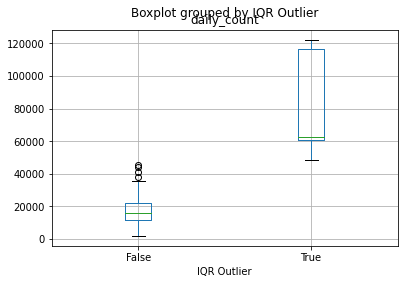

In [12]:
getIQROutlier("daily_count",dailydata)

Here we can see that almost 10% of the daily data is considered an outlier with our model. Lets try some different models for detecting anomalies.

In [13]:
temp = df
temp = temp.drop(columns=["timestamp", "IQR Outlier", "date", "year", "mm", "day"])
temp.head()

,value
0,104
1,100
2,99
3,154
4,120


Here will be using K neares Neighbor clustering model to score anomalies based on their distance from other data point.

In [14]:
knn = 4
nbrs = NearestNeighbors(n_neighbors=knn, metric=distance.euclidean).fit(temp.as_matrix())
distances, indices = nbrs.kneighbors(temp.as_matrix())

anomaly_score = distances[:,knn-1]

anom = pd.DataFrame(anomaly_score, index=df.index, columns=['Anomaly score'])
result = pd.concat((df,anom), axis=1)


C:\Users\brand\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\brand\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
result.nlargest(round(len(df)*.005),'Anomaly score')

,timestamp,value,IQR Outlier,date,year,mm,day,Anomaly score
9285,2015-03-31 03:27:53,13479,True,2015-03-31,2015,03,31,3107.0
13555,2015-04-14 23:17:53,11694,True,2015-04-14,2015,04,14,1785.0
13556,2015-04-14 23:22:53,11899,True,2015-04-14,2015,04,14,1580.0
9284,2015-03-31 03:22:53,10372,True,2015-03-31,2015,03,31,1322.0
9282,2015-03-31 03:12:53,6418,True,2015-03-31,2015,03,31,1169.0
...,...,...,...,...,...,...,...,...
3100,2015-03-09 16:02:53,1464,True,2015-03-09,2015,03,09,21.0
9489,2015-03-31 20:27:53,1401,True,2015-03-31,2015,03,31,21.0
1438,2015-03-03 21:32:53,1585,True,2015-03-03,2015,03,03,20.0
4938,2015-03-16 01:12:53,957,True,2015-03-16,2015,03,16,20.0


here we can see that taking 0.5% of the highest scores gives us anomaly scores in the 20's on up to 3107. Lets plot all the data together and use the anomaly score as a heat index.

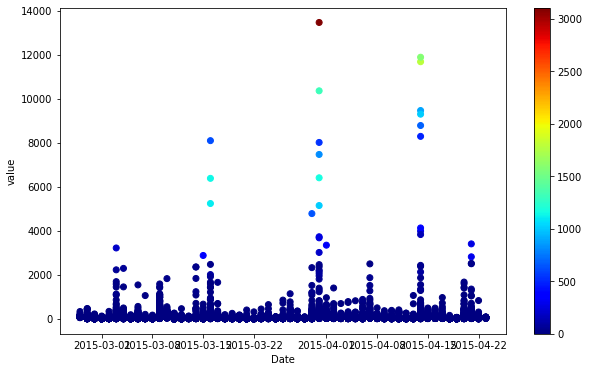

In [16]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
p = ax.scatter(df.date,df.value, c=anomaly_score,cmap='jet')
ax.set_xlabel('Date')
ax.set_ylabel('value')
fig.colorbar(p)
plt.show()


Here is the data again but only plotting the data with the top 00.5% of high Anomaly scores.

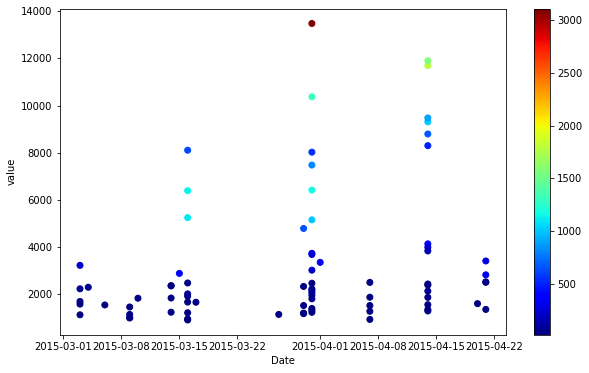

In [17]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
p = ax.scatter(result.nlargest(round(len(df)*.005),'Anomaly score').date,result.nlargest(round(len(df)*.005),'Anomaly score').value, c=result.nlargest(round(len(df)*.005),'Anomaly score')["Anomaly score"],cmap='jet')
ax.set_xlabel('Date')
ax.set_ylabel('value')
fig.colorbar(p)
plt.show()


We can see that even only taking a half percent of the data, some of the data points plotted above don't really look like big anomalies.

Next lets compare this to the IQR Outlier results from earlier. We will plot only the datapoints that were labeled True in our IQR Outliers column.

In [18]:
iqrres = result[result["IQR Outlier"]==True]

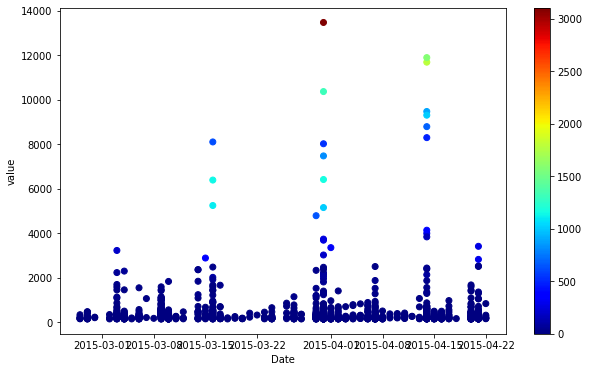

In [19]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
p = ax.scatter(iqrres.date,iqrres.value, c=iqrres["Anomaly score"],cmap='jet')
ax.set_xlabel('Date')
ax.set_ylabel('value')
fig.colorbar(p)
plt.show()


We can see that our IQR Outliers probably considered way too many things to be an anomaly, it seems that taking 0.5% of the highest anomaly scores from our Knearest neighbor model would be a more useful anomaily detector.

lets check train a nearest neighbor model for our daily data and see the results

In [20]:
dailydata['date'] = dailydata["year"] +"-"+dailydata["mm"]+"-"+dailydata["day"]
temp = dailydata
temp = temp.drop(columns=["IQR Outlier", "year", "mm", "day", "date"])
temp.head()
knn = 4
nbrs = NearestNeighbors(n_neighbors=knn, metric=distance.euclidean).fit(temp.as_matrix())
distances, indices = nbrs.kneighbors(temp.as_matrix())

anomaly_score = distances[:,knn-1]

anom = pd.DataFrame(anomaly_score, index=dailydata.index, columns=['Anomaly score'])
result = pd.concat((dailydata,anom), axis=1)


C:\Users\brand\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
C:\Users\brand\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


In [21]:
result.nlargest(round(len(dailydata)*.1),'Anomaly score')


,year,mm,day,daily_count,IQR Outlier,date,Anomaly score
33,2015,03,31,122325,True,2015-03-31,61748.0
47,2015,04,14,116597,True,2015-04-14,56020.0
11,2015,03,09,62570,True,2015-03-09,17043.0
18,2015,03,16,60577,True,2015-03-16,15050.0
54,2015,04,21,48696,True,2015-04-21,7653.0
5,2015,03,03,37832,False,2015-03-03,6548.0


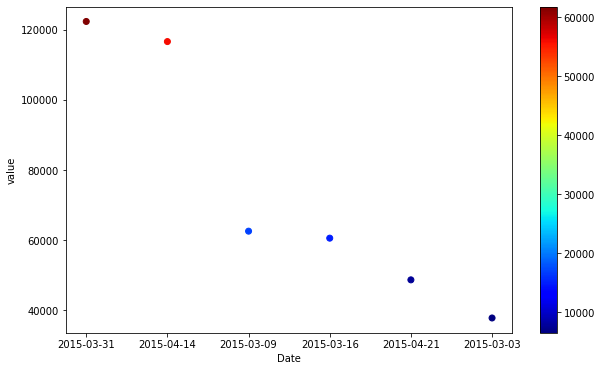

In [22]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
p = ax.scatter(result.nlargest(round(len(dailydata)*.1),'Anomaly score').date,result.nlargest(round(len(dailydata)*.1),'Anomaly score').daily_count, c=result.nlargest(round(len(dailydata)*.1),'Anomaly score')["Anomaly score"],cmap='jet')
ax.set_xlabel('Date')
ax.set_ylabel('value')
fig.colorbar(p)
plt.show()


Here we take the top 10% of highest anomaly scores for daily counts. It seems the last one may not be a large anomily. Lets compare this to the IQR Outliers results for the daily data.

In [23]:
iqrres = result[result["IQR Outlier"]==True]

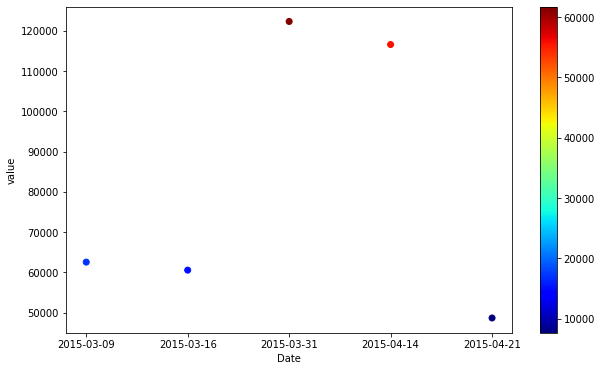

In [24]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
p = ax.scatter(iqrres.date,iqrres.daily_count, c=iqrres["Anomaly score"],cmap='jet')
ax.set_xlabel('Date')
ax.set_ylabel('value')
fig.colorbar(p)
plt.show()


This method has a vey small improvement, possibly because the dataset for daily data is much smaller than the other dataset. I think in general the K nearest neighbor method is better for dectecting anomalies because it scores the anomalies based on their distance. The IQR method we used did not score the anomalies, rather it just marked outliers as true. This puts "outliers" that are less of an anomaly on the same level as large anomalies, the KNN does not have that flaw.